Álvaro Domínguez Calvo <br>
adomingue599@alumno.uned.es

# 0. Dependencies

In [199]:
import re
import os
import time
import nltk
import torch
import datasets
import numpy as np
import pandas as pd
import pickle as pk
import seaborn as sns
from umap import UMAP
import torch.nn as nn
from argparse import Namespace
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import torch.nn.functional as F
from datasets import load_dataset
from nltk.corpus import stopwords
from torch.utils.data import Dataset
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import tqdm_notebook
from datasets import Dataset, DatasetDict
from nltk.tokenize import WhitespaceTokenizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alvarito/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alvarito/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/alvarito/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [9]:
def _get_device():
  is_mps_available: bool = torch.backends.mps.is_available()
  if not is_mps_available:
    display('Metal Performance Shaders is not available')
  else:
    display('Metal Performance Shaders is available')

  return 'mps' if is_mps_available else 'cpu'

DEVICE = _get_device()
SEED = 42

NO_HTML_TAG_PROPERTY = 'no_html'
NO_LINKS_PROPERTY = 'no_links'
REGEX = {
  NO_HTML_TAG_PROPERTY : r'<[^>]+>',
  NO_LINKS_PROPERTY : r'https?://\S+'
}

X_DATA = 'text'
Y_DATA = 'target'

'Metal Performance Shaders is available'

# 1. Introduction

In this work we assess the sentiment analysis task but under the scope of transformers and contextual models. Transformers and contextual models aim to predict the next word of a sentence given the information contained within the latest read information. The fact that they are trained over large datasets leads to models that have good generalization capability since they have a good sample of a language and thus, they do have more knowledge about it.

Transformers like BERT or DistilBERT can be adapted to the classification task, acting like a feature extractors or as a classifiers in case we decide to fine tune them. We will apply sub word tokenization by using the tokenizers associated to the considered transformer. 

All the experiments are run leveraging  <a href="https://huggingface.co" target="_parent">Hugging Face 🤗</a> hub, a large repository of pretrained models trained by the AI community.




## 1.1 Proposed experiments

There are different type of transformers in terms how the data format they were trained with. For example, there exists BERT models that were trained over cased and uncased text.
Another case we should take into account is the existence of stop words. It is possible that the existence of stopwords worsens the final model performance.

With this, we propose two types of experiments: 
At model level:
- considering two pretrained transformers: BERT and DistilBERT.

At representation level, considering:
 - The removal of noisy elements (HTML tags, uncommon characters...)
 - The capitalization of the text (upper and lower)
 - The lemma of the words. We do not apply stemming prodecures since they are based on rigid heuristics to find the root of the words.
 - Stop words removal, considering a fixed set of words that are meaningless in terms of the semantic information they provide.

For simplicity, each experiment is named as: `no_html`, `cased`, `uncased`, `lemmatization` and `stopwords`. 

For each level of representation, we generate a dataset with the considered processing and, for each dataset, we run the proposed transformers.

We do not fine tune any transformer but we use them as a feature extractors which output will be feed to a classifier layer.

# 2. Data processing

In this section we load the dataset and run a short analysis over the dataset in order to evaluate if there are potential noisy elements that could worsen the tokenization and the performance of the trained model.

Since we are using pretrained tokenizers via sub word tokenization we are not using rigid heuristics when defining the boundaries of a word. A rigid heuristic to tokenize a sentence is to consider the whitespace as the boundary of a word, by using `str.split()` Python function. This method yields large vocabularies and, using stemming/lemmatization techniques, we could build smaller vocabularies but in detriment of losing the information contained whitin inflectional form of the words.

Due to we do not want to lose that information and we do no want to deal with large vocabularies, we use the sub word tokenization technique, which is a middle point between these two extremes. However, the major drawback of this technique is that the tokenization is a learnable task and, to tokenize properly sentences, tokenizers should be trained over large textual datasets. Since we do not want to train our own tokenizer, we use the pretrained ones available on Hugging Face.

In [7]:
! gdown -O ./ 1dIzUE8sMpUNN5yfoQgKQpbeefHCsiIcY
! unzip -q Dataset_reviews.zip

Downloading...
From: https://drive.google.com/uc?id=1dIzUE8sMpUNN5yfoQgKQpbeefHCsiIcY
To: /Users/alvaro/Documents/Github/NNLP/Dataset_reviews.zip
100%|██████████████████████████████████████| 5.46M/5.46M [00:00<00:00, 24.8MB/s]


In [10]:
training_set = pd.read_csv("./Dataset_reviews/train_reviews.csv", quotechar='"', header=0, sep=",")
test_set = pd.read_csv("./Dataset_reviews/test_reviews.csv", quotechar='"', header=0, sep=",")

display(training_set.shape)
display(test_set.shape)

(8000, 3)

(2000, 3)

## 2.1 Data experiments

We consider four data formats according to the proposed four experiments related to the data representation. We define the class `DataProcessor` to define static methods that process the reviews.

In [49]:
class DataProcessor:

    def __init__(self) -> None:
        self.lemmatizer = WordNetLemmatizer()
        self.stops = set(stopwords.words("english"))

    @staticmethod
    def remove_html_tags_urls(text: str):
        no_html = re.sub(REGEX[NO_HTML_TAG_PROPERTY], '', text)

        no_url = re.sub(REGEX[NO_LINKS_PROPERTY], '', no_html)
        result = no_url
        
        return result
        
    @staticmethod
    def lower_case(text: str):
        return text.lower()
        
    def _determine_wordnet_tag(self, nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:          
            return None
            
    def lemmatize(self, text: str):
        tagged_text = nltk.pos_tag(text.split())
        wordnet_tagged = map(lambda x: (x[0], self._determine_wordnet_tag(x[1])), tagged_text)
            
        lemmatized_text: list = list()
        for word, pos_tag in wordnet_tagged:
            if pos_tag is None:
                lemmatized_text.append(word)
            else:        
                lemmatized_text.append(self.lemmatizer.lemmatize(word, pos_tag))

        return " ".join(lemmatized_text)
        
    def remove_stop_words(self, text: str):
        words = text.split()
        return " ".join([word for word in words if not word in self.stops])
  

We take a look of the 20 first reviews. We notice that there are some HTML tags that we do not want to feed to the pretrained models. We define a function to delete these items.

In [16]:
display(training_set.head(15).at[5, 'review'])

'Shame Shame Shame on UA/DW for what you do! <br /><br />I was appalled. <br /><br />Do NOT take kids to see this movie. The humor is totally inappropriate for children - plus they\'ll be bored and disappointed. Certainly *we all* have read Theo\'s wonderful children book and certainly we have expectations...but this is pure trash. Dr. Seuss would be ashamed and certainly would\'ve never given his "thumbs up" at such a dastardly attempt to capitalize on a classic.<br /><br />What a pity. <br /><br />Spend your money on the book. If you own a copy, then buy the book and donate it to a Toys for Tots program. This movie is NOT worth a "free" ticket viewing.<br /><br />Stick with the book. The tv cartoon version works well if you want a visual portrayal - save your money...seriously. SAVE your money - it will be on cable by saint patty\'s day.<br /><br />Shame shame shame on what they do!!'

In all the experiments we consider the removal of the HTML tags and URLs (`no_html_url`) since we do not expect they yield semantic information about the review.
Given this, we have two types of representation in terms of the capitalization of the review: `cased` and `uncased`. We run a lemmatization process of the words contained within the review, splitting the review by whitespace. Lastly, we consider the removal or predefined English stopwords. For simplicity, we do not consider corpus-specific stopwords. To sum up, we have six experiments and we apply the text processing functions in the given order:
- `no_html_url` & `cased`
- `no_html_url` & `uncased`
- `no_html_url` & `cased` & `stopwords`
- `no_html_url` & `uncased` & `stopwords`
- `no_html_url` & `lemmatized` & `cased` & `stopwords`
- `no_html_url` & `lemmatized` & `uncased` & `stopwords`

Now we generate the different datasets to run the experiments. We merge training and test splits to process all the data. Later on, we will split the dataset in train, validation and test splits in a stratified fashion with respect to the target variable to predict in order to preserve the balance of the dataset w.r.t. this variable.

In [17]:
dataset: pd.DataFrame = pd.concat([training_set, test_set], ignore_index=True)
dataset.head()

,id,review,sentiment
0,17527,People tried to make me believe that the premi...,negative
1,24155,I have been wanting to see cut since the day i...,positive
2,21972,This movie is terrible. The suspense is spent ...,negative
3,4565,I hope she can keep acting and directing. She'...,positive
4,22098,I fell in love with this silent action drama. ...,positive


In [23]:
def save_dataset(path: str, name: str, df: pd.DataFrame):
 try:
  os.mkdir(path)
 except Exception as e:
  print('Folder already created')
  pass
 df.to_csv(f'{path}{name}', sep=',', quotechar='"') #, index=False, header=False)

In [50]:
NO_HTML_URL = 'no_html_url'
CASED = 'cased'
UNCASED = 'uncased'
LEMMATIZED = 'lemmatized'
STOPWORDS = 'stopwords'


NO_HTML_URL_CASED = f'{NO_HTML_URL}_{CASED}'
NO_HTML_URL_UNCASED = f'{NO_HTML_URL}_{UNCASED}'

NO_HTML_URL_CASED_STOPWORDS = f'{NO_HTML_URL}_{CASED}_{STOPWORDS}'
NO_HTML_URL_UNCASED_STOPWORDS = f'{NO_HTML_URL}_{UNCASED}_{STOPWORDS}'

NO_HTML_URL_LEMMATIZED_CASED_STOPWORDS= f'{NO_HTML_URL}_{LEMMATIZED}_{CASED}_{STOPWORDS}'
NO_HTML_URL_LEMMATIZED_UNCASED_STOPWORDS = f'{NO_HTML_URL}_{LEMMATIZED}_{UNCASED}_{STOPWORDS}'

EXPERIMENTS_BASE_PATH = './experiments/data/'

EXPERIMENTS = {

 NO_HTML_URL_CASED : {
  'path' : f'{EXPERIMENTS_BASE_PATH}{NO_HTML_URL_CASED}/',
  'csv_name' : f'{NO_HTML_URL_CASED}.csv'
 },

 NO_HTML_URL_UNCASED : {
  'path' : f'{EXPERIMENTS_BASE_PATH}{NO_HTML_URL_UNCASED}/',
  'csv_name' : f'{NO_HTML_URL_UNCASED}.csv'
 },

 NO_HTML_URL_CASED_STOPWORDS : {
  'path' : f'{EXPERIMENTS_BASE_PATH}{NO_HTML_URL_CASED_STOPWORDS}/',
  'csv_name' : f'{NO_HTML_URL_CASED_STOPWORDS}.csv'
 },

 NO_HTML_URL_UNCASED_STOPWORDS : {
  'path' : f'{EXPERIMENTS_BASE_PATH}{NO_HTML_URL_UNCASED_STOPWORDS}/',
  'csv_name' : f'{NO_HTML_URL_UNCASED_STOPWORDS}.csv'
 },

 NO_HTML_URL_LEMMATIZED_CASED_STOPWORDS : {
  'path' : f'{EXPERIMENTS_BASE_PATH}{NO_HTML_URL_LEMMATIZED_CASED_STOPWORDS}/',
  'csv_name' : f'{NO_HTML_URL_LEMMATIZED_CASED_STOPWORDS}.csv'
 },
 NO_HTML_URL_LEMMATIZED_UNCASED_STOPWORDS : {
  'path' : f'{EXPERIMENTS_BASE_PATH}{NO_HTML_URL_LEMMATIZED_UNCASED_STOPWORDS}/',
  'csv_name' : f'{NO_HTML_URL_LEMMATIZED_UNCASED_STOPWORDS}.csv'
 },
}

TRAIN_SPLIT_PATH = 'experiments/data/train_validation/train.pkl'
VALIDATION_SPLIT_PATH =  'experiments/data/train_validation/validation.pkl'
TEST_SPLIT_PATH = 'experiments/data/train_test/test.pkl'

data_processor = DataProcessor()

And lastly, we define some functions to store the `csv` files.

In [21]:
def rename_columns_for_experiment(experiment_name: str, data: pd.DataFrame):
 data_copy = data.copy(deep=True)
 data_copy = data_copy[['id', experiment_name, 'sentiment']]
 data_copy.columns = ['id', 'review', 'sentiment']

 return data_copy

def persist_csv_dataset(experiment_name: str, data: pd.DataFrame):
 experiment_info = EXPERIMENTS[experiment_name]

 renamed_data = rename_columns_for_experiment(experiment_name, data)
 save_dataset(experiment_info['path'], experiment_info['csv_name'], renamed_data)

### 1: `no_html_url_cased`

In [24]:
dataset[NO_HTML_URL_CASED] = dataset['review'].apply(lambda x: DataProcessor.remove_html_tags_urls(x))
persist_csv_dataset(NO_HTML_URL_CASED, dataset)

### 2: `no_html_url_uncased`

In [25]:
dataset[NO_HTML_URL_UNCASED] = dataset[NO_HTML_URL_CASED].apply(lambda x: DataProcessor.lower_case(x))
persist_csv_dataset(NO_HTML_URL_UNCASED, dataset)

### 3: `no_html_url_cased_stopwords`

In [26]:
dataset[NO_HTML_URL_CASED_STOPWORDS] = dataset[NO_HTML_URL_CASED].apply(lambda x: data_processor.remove_stop_words(x))
persist_csv_dataset(NO_HTML_URL_CASED_STOPWORDS, dataset)

### 4: `no_html_url_uncased_stopwords`

In [27]:
dataset[NO_HTML_URL_UNCASED_STOPWORDS] = dataset[NO_HTML_URL_UNCASED].apply(lambda x: data_processor.remove_stop_words(x))
persist_csv_dataset(NO_HTML_URL_UNCASED_STOPWORDS, dataset)

### 5: `no_html_url_lemmatized_cased_stopwords`

In [51]:
def lemmatize_cased_stopwords(review: str):
    lemmatized = data_processor.lemmatize(review)
    no_stop_words = data_processor.remove_stop_words(lemmatized)
    return no_stop_words

dataset[NO_HTML_URL_LEMMATIZED_CASED_STOPWORDS] = dataset[NO_HTML_URL_CASED].apply(lambda x: lemmatize_cased_stopwords(x))
persist_csv_dataset(NO_HTML_URL_LEMMATIZED_CASED_STOPWORDS, dataset)

### 6: `no_html_url_lemmatized_uncased_stopwords`

In [52]:
def lemmatized_uncased_stopwords(review: str):
    lemmatized: str = data_processor.lemmatize(review)
    uncased: str = DataProcessor.lower_case(lemmatized)
    no_stop_words: str = data_processor.remove_stop_words(uncased)
    return no_stop_words

dataset[NO_HTML_URL_LEMMATIZED_UNCASED_STOPWORDS] = dataset[NO_HTML_URL_CASED].apply(lambda x: lemmatized_uncased_stopwords(x))
persist_csv_dataset(NO_HTML_URL_LEMMATIZED_UNCASED_STOPWORDS, dataset)

We save the resulting dataset too.

In [53]:
save_dataset('./experiments/data/full/', 'review_experiment.csv', dataset)

Folder already created


Lastly, we split the dataset into train, validation and test splits. We store the indexes of these splits in `CSV` format too.

In [54]:
def format_index_split(df: pd.DataFrame):
 index_df: pd.DataFrame = df.index.to_list()
 index_df.columns = ['index']
 return index_df

In [55]:
train, test = train_test_split(dataset, stratify=dataset['sentiment'], test_size=0.2, random_state=SEED)

train_index = train.index.to_list()
with open('./experiments/data/train_test/train.pkl', 'wb') as f:
 pk.dump(train_index, f)

test_index = test.index.to_list()
with open('./experiments/data/train_test/test.pkl', 'wb') as f:
 pk.dump(test_index, f)

In [56]:
train, validation = train_test_split(train, stratify=train['sentiment'], test_size=0.2, random_state=SEED)

train_index_v = train.index.to_list()
with open('./experiments/data/train_validation/train.pkl', 'wb') as f:
 pk.dump(train_index_v, f)

validation_index = validation.index.to_list()
with open('./experiments/data/train_validation/validation.pkl', 'wb') as f:
 pk.dump(validation_index, f)

And we define a function to retrieve the split indexes

In [57]:
def get_indexes_split(path: str):
 with open(path, 'rb') as f:
  return pk.load(f)

### Word count analysis

We analyse the number of times the top 25 words appear in each proposed experiment in order to compare the resulting data obtained from the processing functions.

We define a function to plot the most common words tokenizing each review by whitespace.

In [194]:
class ExperimentDescriptor:

    def __init__(self, experiments: dict, data: pd.DataFrame) -> None:
        self.experiments: dict = experiments
        self.data: pd.DataFrame = data
        self.tokenizer = WhitespaceTokenizer()

    def word_count_per_experiment(self, limit: int):
        fig = plt.figure(figsize=(20,45))
        # fig.suptitle('Counts word per experiment')
        plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)

        subfigs = fig.subfigures(nrows = len(self.experiments.keys()), ncols = 1)

        experiment_index: int = 0
        for experiment in self.experiments:
            
            subfig = subfigs[experiment_index]
            subfig.suptitle(f'Experiment: {experiment}')
            axes = subfig.subplots(nrows=1, ncols=2)

            concatenated_per_class: pd.DataFrame = ExperimentDescriptor.get_experiment_data(experiment, self.data)
            for class_index, concatenated_text in enumerate(concatenated_per_class.text):
                                
                count_words = ExperimentDescriptor.count_words(concatenated_text, limit, self.tokenizer)
                words = list(map(lambda x: x[0], count_words.index.to_list()))

                ExperimentDescriptor.plot_bar_count(ax=axes[class_index], x=words, y=count_words.values, title=f'{concatenated_per_class.CLASS[class_index]}')
            experiment_index += 1

    def plot_confusion_matrices(self, classes):
        
        fig = plt.figure(figsize=(10, 30))

        plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)

        subfigs = fig.subfigures(nrows = len(self.experiments.keys()), ncols = 2)

        experiment_index: int = 0
        for experiment in self.experiments:
            subfig = subfigs[experiment_index]
            # subfig.suptitle(f'Experiment: {experiment}. validation/test')
            left_subfig = subfig[0].subplots(nrows=1, ncols=1)
            
            confusion_matrix_result_validation = self.data.at['predictions_validation', experiment]['confusion_matrix'] #self.data[experiment]['confusion_matrix']
            disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_result_validation, display_labels=classes)
            disp.plot(cmap="Blues", values_format=".2f", ax=left_subfig, colorbar=False)
            subfigs[experiment_index, 0].suptitle(f'{experiment} (validation)')

            rigth_subfig = subfig[1].subplots(nrows=1, ncols=1)
            confusion_matrix_result_test = self.data.at['test_predictions', experiment]['confusion_matrix']
            disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_result_test, display_labels=classes)
            disp.plot(cmap="viridis", values_format=".2f", ax=rigth_subfig, colorbar=False)
            subfigs[experiment_index, 1].suptitle(f'{experiment} (test)')

            experiment_index += 1

    @staticmethod
    def get_experiment_data(experiment: str, data: pd.DataFrame):

        data_columns: pd.DataFrame = pd.DataFrame({'text' : data[experiment], 'CLASS' : data.sentiment}) #TODO: sentiment should be named as target (more abstract).
        concatenated_texts = data_columns.groupby(["CLASS"]).apply(lambda x: x['text'].sum())
        grouped_df = pd.DataFrame({"CLASS": concatenated_texts.index, "text": concatenated_texts.values})

        return grouped_df

    @staticmethod
    def count_words(text: str, limit: int, tokenizer: WhitespaceTokenizer):
        tokens = tokenizer.tokenize(text)
        df_tokens = pd.DataFrame(tokens)
        return df_tokens.value_counts().nlargest(limit)

    @staticmethod
    def plot_bar_count(ax, x: list, y: pd.Series, title: str):
        sns.barplot(x=x, y=y, ax=ax)
        ax.set_title(title)
        ax.set_ylabel('Number of Occurrences', fontsize=12)
        ax.set_xlabel('Word', fontsize=12)
        ax.xaxis.set_tick_params(rotation=75)

In [152]:
a = pd.DataFrame(data=results)
display(a)
a.at['test_predictions', 'no_html_url_uncased']['confusion_matrix']

,no_html_url_uncased,no_html_url_uncased_stopwords,no_html_url_lemmatized_uncased_stopwords,no_html_url_cased,no_html_url_cased_stopwords,no_html_url_lemmatized_cased_stopwords
predictions_validation,"{'predictions': ['positive', 'negative', 'posi...","{'predictions': ['positive', 'negative', 'posi...","{'predictions': ['positive', 'negative', 'posi...","{'predictions': ['positive', 'negative', 'posi...","{'predictions': ['positive', 'negative', 'posi...","{'predictions': ['positive', 'negative', 'posi..."
test_predictions,"{'predictions': ['negative', 'positive', 'nega...","{'predictions': ['negative', 'positive', 'nega...","{'predictions': ['negative', 'positive', 'nega...","{'predictions': ['negative', 'positive', 'nega...","{'predictions': ['negative', 'positive', 'nega...","{'predictions': ['negative', 'positive', 'nega..."


array([[0.8225324 , 0.1774676 ],
       [0.15145436, 0.84854564]])

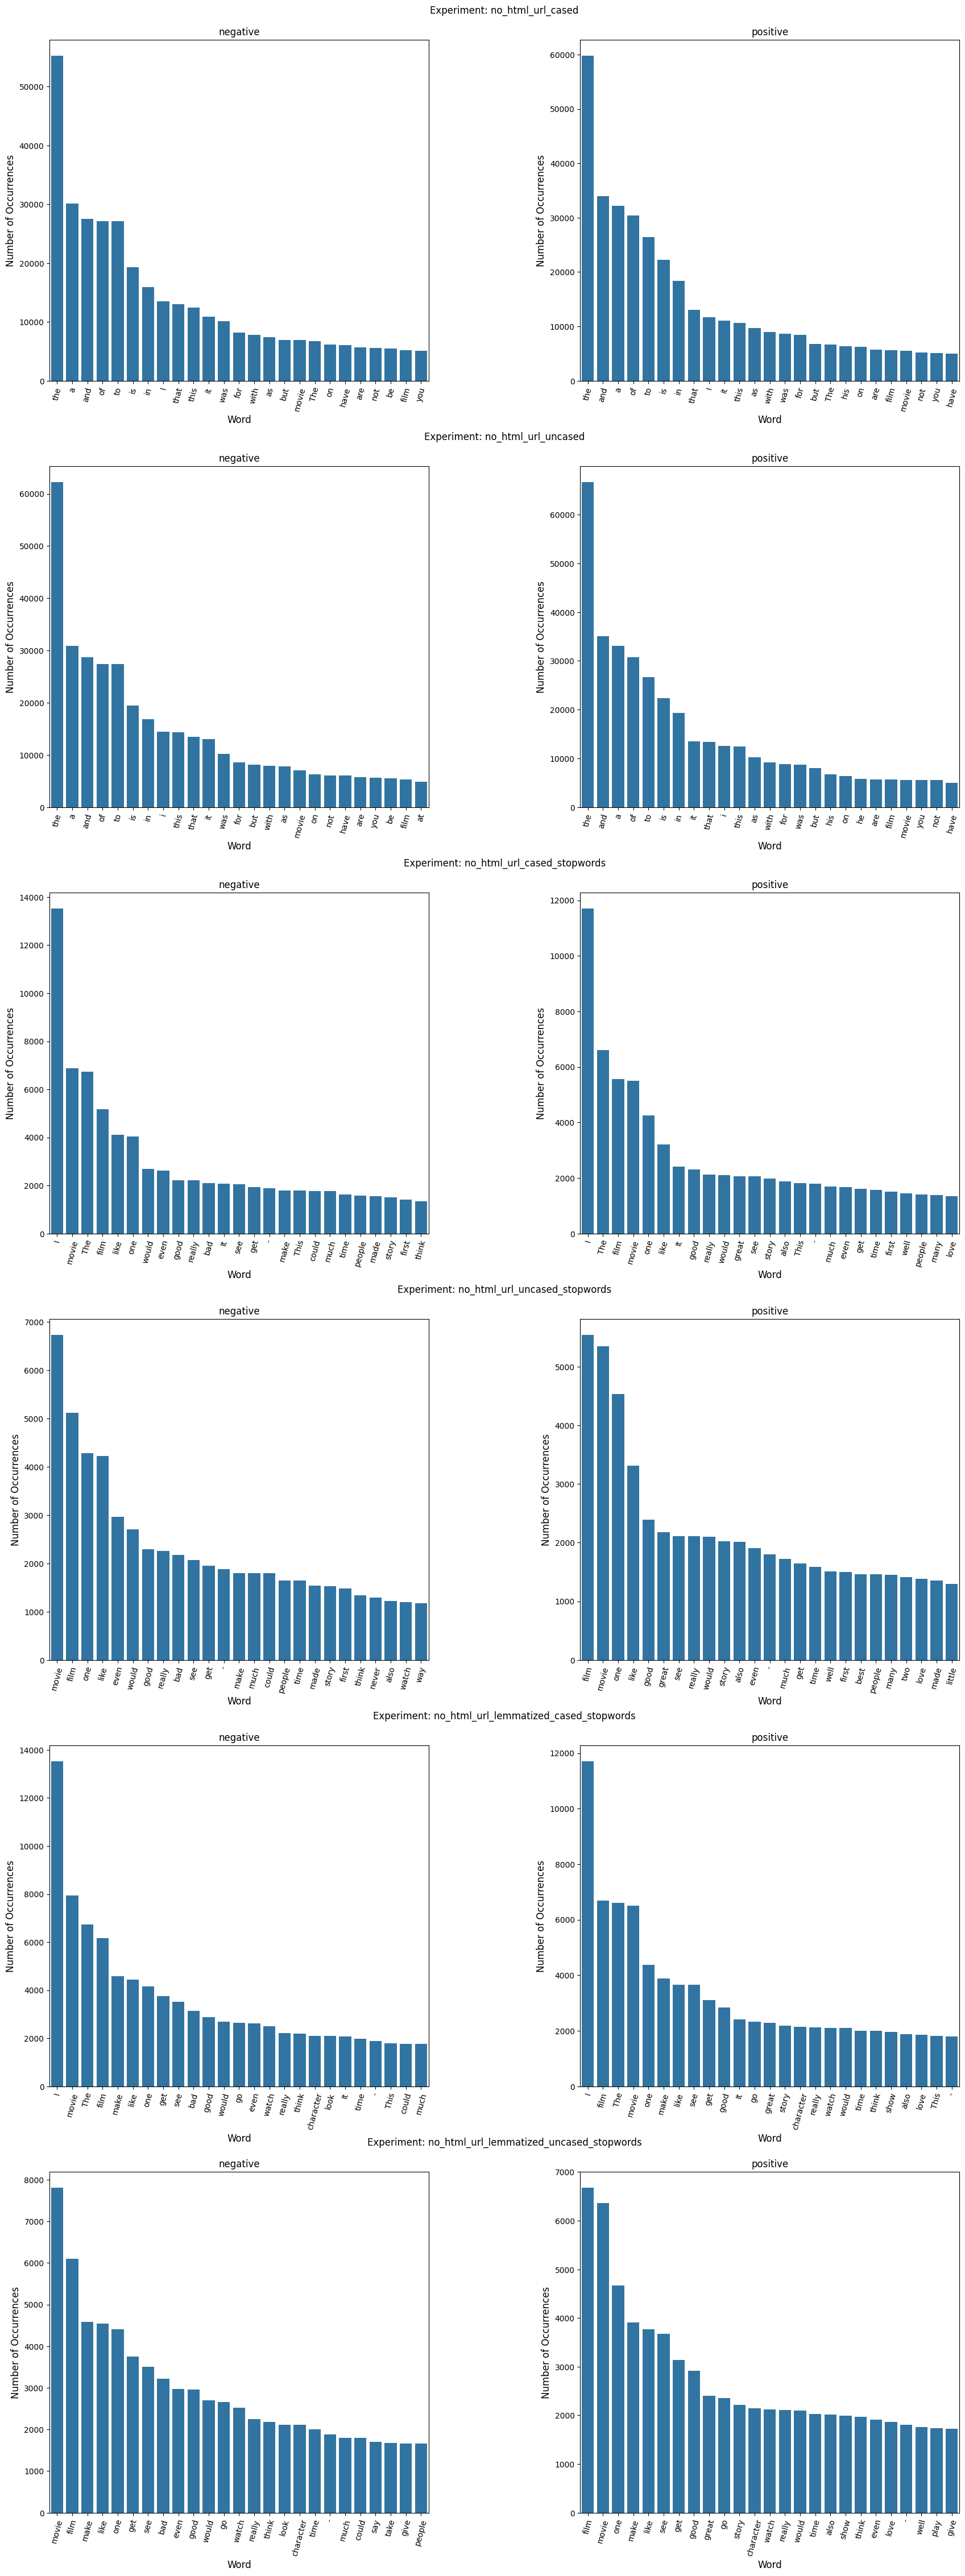

In [59]:
descriptor = ExperimentDescriptor(experiments=EXPERIMENTS, data=dataset)
descriptor.word_count_per_experiment(25)

We can observe that applying the removal of stopwords and lemmatization yields vocabularies that contains potential words that could be discriminative when determining their polarity. However, the fact of removing words could affect to the performance of the transformers since they are sequential models that are trained over textual data, including stopwords.

### Loading splits

Now we define a class to load the train, validation and test splits given the data experiments we computed before.

In [60]:
class SplitLoader:

    def __init__(self, experiment_csv_path: str, train_path: str, validation_path: str, test_path: str) -> None:
      self.csv: pd.DataFrame = pd.read_csv(experiment_csv_path, index_col=0)
      self.train_path = train_path
      self.validation_path = validation_path
      self.test_path = test_path

      self.train_split: pd.DataFrame = self.read_train_split()
      self.validation_split: pd.DataFrame = self.read_validation_split()
      self.test_split: pd.DataFrame = self.read_test_split()

    def read_train_split(self):
      with open(self.train_path, 'rb') as f:
        train_split = pk.load(f)
      return self.csv.iloc[train_split]
    
    def read_validation_split(self):
      with open(self.validation_path, 'rb') as f:
        validation_split = pk.load(f)
      return self.csv.iloc[validation_split]
    
    def read_test_split(self):
      with open(self.test_path, 'rb') as f:
        test_split = pk.load(f)
      return self.csv.iloc[test_split]
    
    def unifiy_train_validation(self):
      return pd.concat([self.train_split, self.validation_split])


### Class distributions and size review

Before going into the experiments, we need to evaluate the balance of the dataset with respect to the target class to predict. To avoid the model learn biases due to the imbalance of the dataset, we split the data in a stratified fashion in the last section. Nonetheless, we will evaluate the imbalance of every split.

On the other hand, transformers has a fixed size of context, that is, the maximum number of tokens the transformer is able to process. We analyse the distribution of the number of tokens we have per target class in the training, validation and test set.

For example, we load the data regarding the experiment 1.

In [61]:
info_experiment = EXPERIMENTS[NO_HTML_URL_CASED]
experiment_csv_path = f'{info_experiment["path"]}{info_experiment["csv_name"]}'
split_loader = SplitLoader(experiment_csv_path, TRAIN_SPLIT_PATH, VALIDATION_SPLIT_PATH, TEST_SPLIT_PATH)

In [62]:
train_df: pd.DataFrame = split_loader.train_split
validation_df: pd.DataFrame = split_loader.validation_split
test_df: pd.DataFrame = split_loader.test_split


Text(0.5, 1.0, 'Training count')

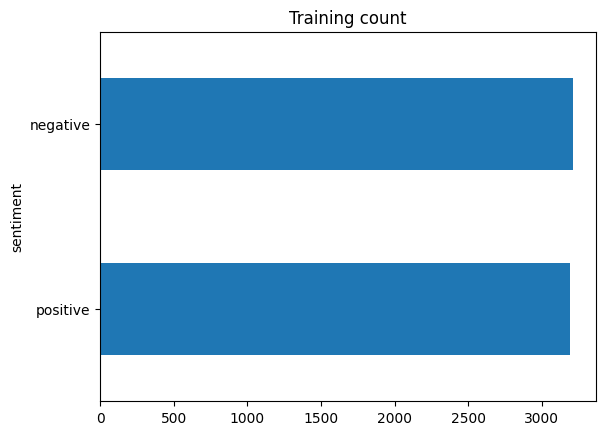

In [63]:
train_df['sentiment'].value_counts(ascending=True).plot.barh()
plt.title('Training count')


Text(0.5, 1.0, 'Validation count')

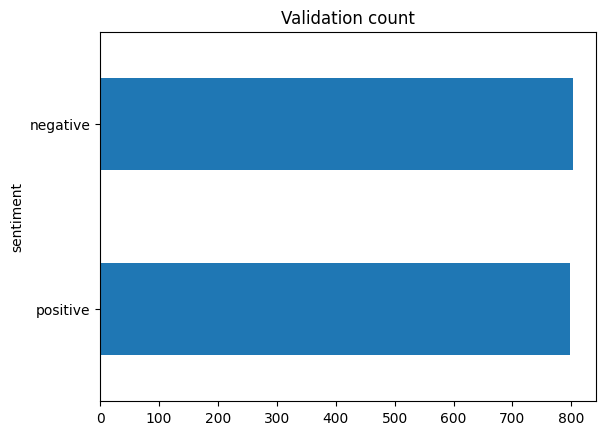

In [64]:
validation_df['sentiment'].value_counts(ascending=True).plot.barh()
plt.title('Validation count')

Text(0.5, 1.0, 'Test count')

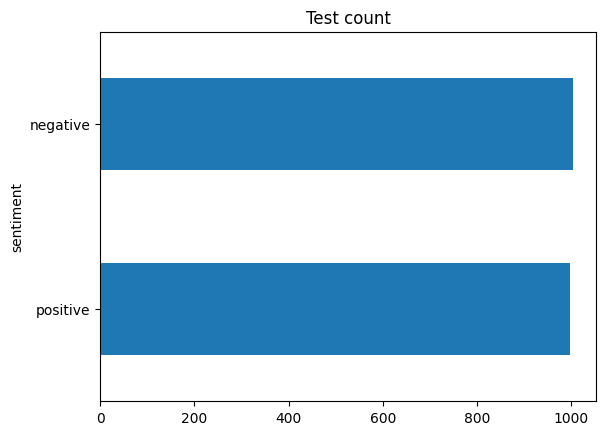

In [65]:

test_df['sentiment'].value_counts(ascending=True).plot.barh()
plt.title('Test count')

As we expected, the three splits are balanced w.r.t. the target variable. Let's take a look to the average number of tokens per split and sentiment.

In [66]:

def box_plot_split(split: pd.DataFrame, split_name):
 counts = list(split['review'].str.split().apply(len))
 data = {
  'Word count' : counts,
  'Sentiment' : list(split['sentiment'])
 }
 dataframe = pd.DataFrame(data= data)
 sns.set(style='whitegrid')
 facecolor = '#eaeaf2'
 fig, ax = plt.subplots(figsize=(10, 6), facecolor=facecolor)

 ax = sns.boxplot(
  y=data['Word count'],
  x=dataframe['Sentiment'],
  hue=dataframe['Sentiment'],
  flierprops=dict(marker='x', markersize=4)
 )

 font_color = '#525252'

 title = 'Distribution of number of word per class'
 fig.suptitle(title, y=.97, fontsize=22, color=font_color)
 subtitle = split_name
 plt.title(subtitle, fontsize=12, pad=10, color=font_color)

 lines = ax.get_lines()
 categories = ax.get_xticks()

 for cat in categories:
     y = round(lines[4+cat*6].get_ydata()[0],1) 
     ax.text(
         cat, 
         y, 
         f'{y}', 
         ha='center', 
         va='center', 
         fontweight='semibold', 
         size=12,
         color='white',
         bbox=dict(facecolor='#828282', edgecolor='#828282')
     )
 plt.show()

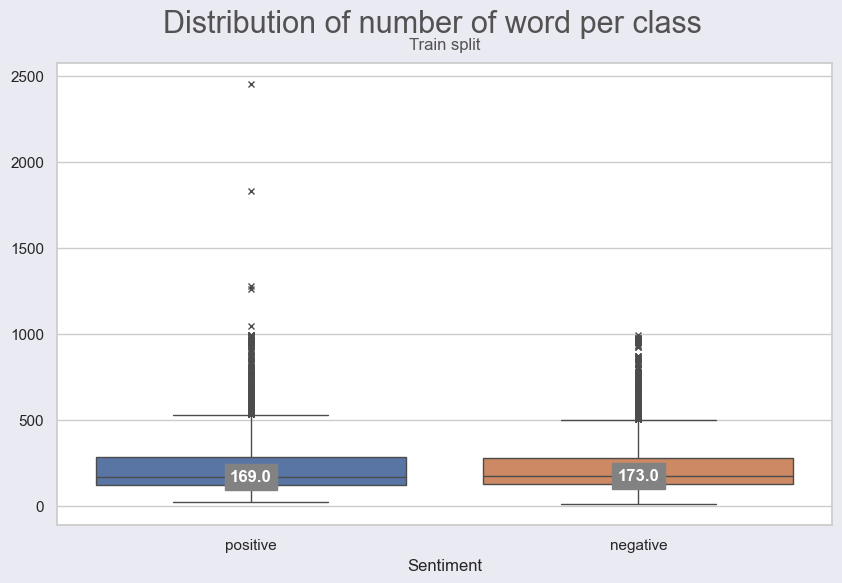

In [67]:
box_plot_split(train_df, 'Train split')

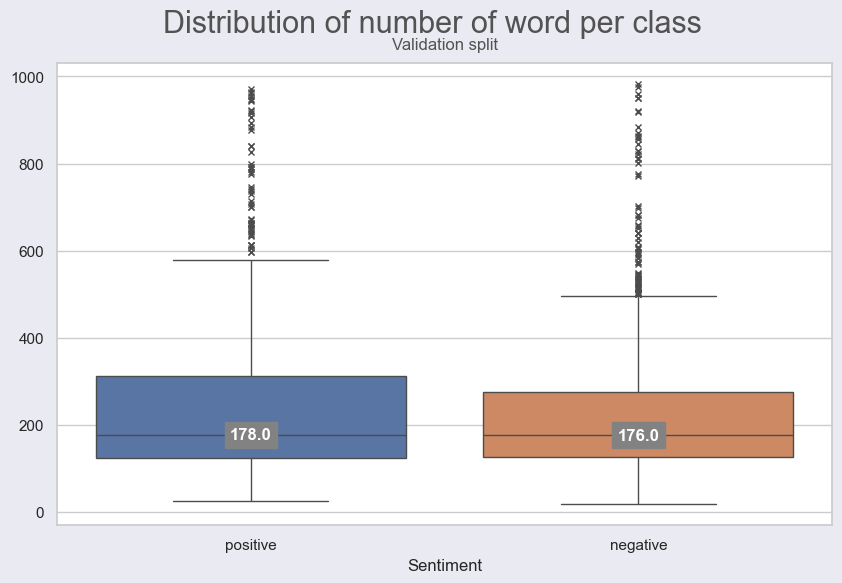

In [68]:
box_plot_split(validation_df, 'Validation split')

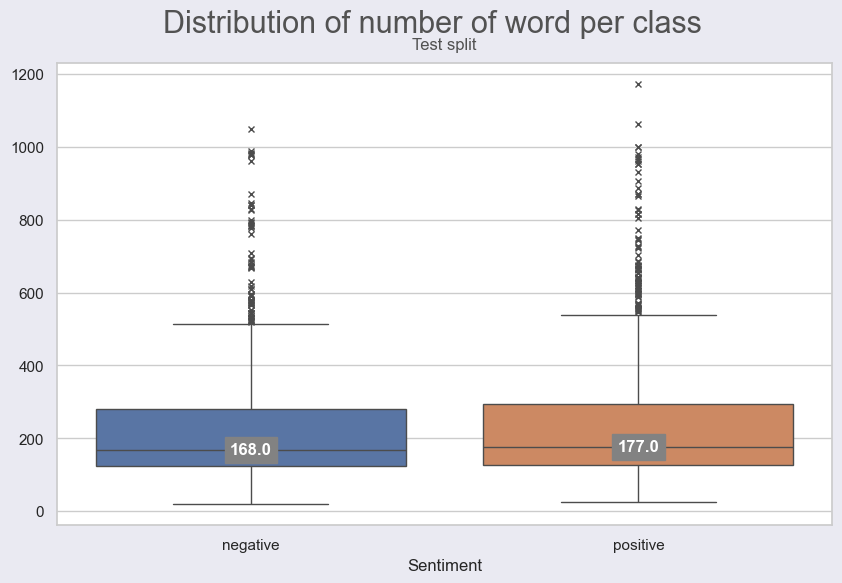

In [69]:
box_plot_split(test_df, 'Test split')

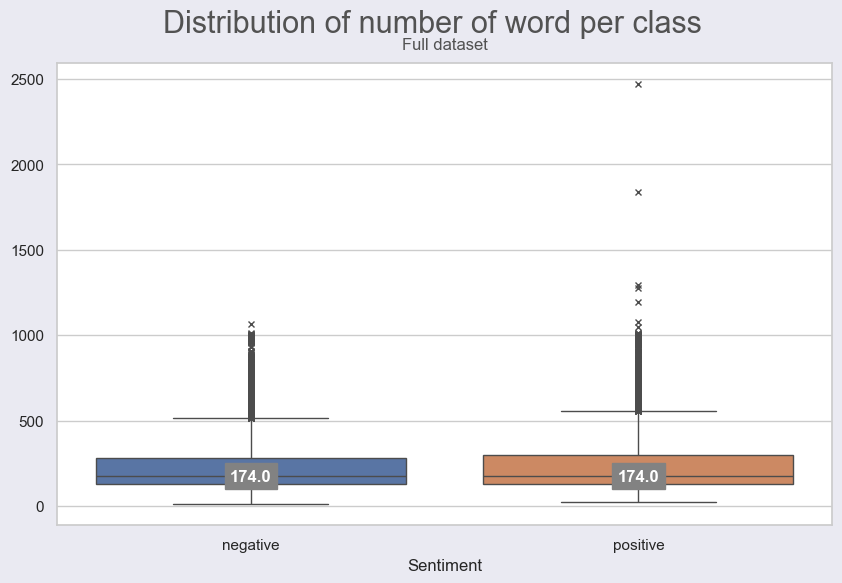

In [70]:
box_plot_split(dataset, 'Full dataset')

The median number of words per class in the entire dataset is 173 for each class. Per split, we have almost the same median value.
Note that there are reviews that contain more than 512 tokens. Tokenizers will truncate the reviews in order to be processed by the transformers.

# 3. Proposed architectures

In this work we consider two approaches to use pretrained models.
* Freezing the model parameters to use the transformer as a feature extractor.
* Use a pretrained model for the sentiment analysis task.

Note that we could fine tune our own model to the given task. In our work, we do not consider that in the experiments.

When using the feature extractor approach, we need to choose a machine learning algorithm or a feed forward neural network layer since the output of the feature extractor corresponds to the computed hidden state for the review in question. For simplicity, we use logistic regression as the classifier layer.

For all the experiments we measure the precision per class in confusion matrices. The precision is defined as:

$precision = \frac{TP}{TP + FP}$ where $TP$ are the true positives and $FP$ are the false positives.

## 3.1. Tokenizers

Each transformer has its own tokenizer since they are trained over different textual data and hence, they build different vocabularies. To encapsulate the tokenization via pretrained tokenizers, we define the class `TransformerTokenizer`.

In [71]:
class TransformerTokenizer:
    def __init__(self, tokenizer) -> None:
        self.tokenizer = tokenizer
    
    def tokenize(self, batch):
        return self.tokenizer(batch[X_DATA], padding = True, truncation=True)
    
    def untokenize_to_string(self, tokenized_sentence):
        return self.tokenizer.convert_tokens_to_string(tokenized_sentence)
    
    def untokenize_to_list(self, tokenized_sentence):
        return self.tokenizer.convert_ids_to_tokens(tokenized_sentence)

For example, if we use the DistilBERT tokenizer:

We use the DistilBERT and BERT tokenizers to represent the textual information into a format that is compatible with these transformers.

For DistilBERT:

In [72]:
from transformers import DistilBertTokenizer

model_ckpt = "distilbert-base-cased"
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
display(distilbert_tokenizer.model_input_names)
display(distilbert_tokenizer.model_max_length)

tt_distil_bert = TransformerTokenizer(distilbert_tokenizer)



tokenizer_config.json: 100%|██████████| 29.0/29.0 [00:00<00:00, 90.0kB/s]
vocab.txt: 100%|██████████| 213k/213k [00:00<00:00, 3.30MB/s]
tokenizer.json: 100%|██████████| 436k/436k [00:00<00:00, 12.9MB/s]
config.json: 100%|██████████| 465/465 [00:00<00:00, 1.17MB/s]


['input_ids', 'attention_mask']

512

We test the tokenizer function

In [73]:
sample_review = "This is a test to tokenize a sentence. 🤗"
print(sample_review)
sample_tokenized = tt_distil_bert.tokenize({X_DATA : sample_review})
display(sample_tokenized)

This is a test to tokenize a sentence. 🤗


{'input_ids': [101, 1188, 1110, 170, 2774, 1106, 22559, 3708, 170, 5650, 119, 100, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

If we convert back the tokenized review we get:

In [74]:
tokens = tt_distil_bert.untokenize_to_list(sample_tokenized.input_ids)
print(tokens)

['[CLS]', 'This', 'is', 'a', 'test', 'to', 'token', '##ize', 'a', 'sentence', '.', '[UNK]', '[SEP]']


Let's undo the tokenization.

In [75]:
tt_distil_bert.untokenize_to_string(tokens)

'[CLS] This is a test to tokenize a sentence . [UNK] [SEP]'

We observe some words has been split with the prefix `##`. This denotes the preceding string is not whitespace.

Also we observe the tokens `[CSL]` and `[SEP]` to the start and end of the sequence. Note that the tokenizer is not able to detect emojis.

Now we are ready to implement a function that tokenizes the entire dataset using the `map` function of the `DatasetDict` class. We define the DatasetLoader to encapsulate this functionality.

In [76]:
class DatasetLoader:
    def __init__(self, split_loader: SplitLoader) -> None:

        self.split_loader = split_loader
        self.dataset_dict = None

        self.tokenized_data = None
    def load_dataset_with_validation(self):
        
        train_split, validation_split, test_split = DatasetLoader.load_splits_with_validation(self.split_loader)
        train_dict = Dataset.from_pandas(train_split)
        validation_dict = Dataset.from_pandas(validation_split)
        test_dict = Dataset.from_pandas(test_split)

        dataset_dict = DatasetDict()

        dataset_dict['train'] = train_dict
        dataset_dict['validation'] = validation_dict
        dataset_dict['test'] = test_dict

        self.dataset_dict = dataset_dict
    
    def load_dataset(self):
        train_split, test_split = DatasetLoader.load_splits(self.split_loader)
        
        train_dict = Dataset.from_pandas(train_split)
        test_dict = Dataset.from_pandas(test_split)

        dataset_dict = DatasetDict()

        dataset_dict['train'] = train_dict
        dataset_dict['test'] = test_dict

        self.dataset_dict = dataset_dict

    def tokenize_dataset(self, tokenizer: TransformerTokenizer):
        return self.dataset_dict.map(tokenizer.tokenize, batched=True, batch_size=None)

    def get_tokenized_data(self):
        return self.tokenize_data
    
    @staticmethod
    def load_splits_with_validation(split_loader: SplitLoader):
        train_split = split_loader.train_split.reset_index(drop=True)
        validation_split = split_loader.validation_split.reset_index(drop=True)
        test_split = split_loader.test_split.reset_index(drop=True)
        
        columns = ['id', X_DATA, Y_DATA]
        train_split.columns = columns
        validation_split.columns = columns
        test_split.columns = columns
        return train_split, validation_split, test_split
    
    @staticmethod
    def load_splits(split_loader: SplitLoader):
        train_split = split_loader.unifiy_train_validation().reset_index(drop=True)
        test_split = split_loader.test_split.reset_index(drop=True)

        columns = ['id', X_DATA, Y_DATA]
        train_split.columns = columns
        test_split.columns = columns

        return train_split, test_split

For example, for the experiment 1 `no_html_url_cased`

In [77]:
info_experiment = EXPERIMENTS[NO_HTML_URL_CASED]
experiment_csv_path = f'{info_experiment["path"]}{info_experiment["csv_name"]}'

#Load the splits
split_loader = SplitLoader(experiment_csv_path, TRAIN_SPLIT_PATH, VALIDATION_SPLIT_PATH, TEST_SPLIT_PATH)

# Load the DatasetDict
experiment_1 = DatasetLoader(split_loader)

#Load the tokenizer
tt_distil_bert = TransformerTokenizer(distilbert_tokenizer)

In [78]:
experiment_1.load_dataset_with_validation()
tokenized_data = experiment_1.tokenize_dataset(tt_distil_bert)
tokenized_data

Map: 100%|██████████| 2000/2000 [00:02<00:00, 900.37 examples/s]


DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'target', 'input_ids', 'attention_mask'],
        num_rows: 6400
    })
    validation: Dataset({
        features: ['id', 'text', 'target', 'input_ids', 'attention_mask'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['id', 'text', 'target', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

Now we are ready to run the experiments.

# 4. Experiments

For every representation we have of the data, we consider two usages of transformers: Using them as feature extractors or fine tuning them to the specific dataset.
We consider two transformers with their respective tokenizers: DistilBERT and BERT

## 4.1. Transformers as feature extractors

In the next experiments, we will play with the transformers but freezing their parameters in order to use them as a feature extractors. The extracted features can be exploited in downstream tasks by feeding them onto another feed forward layer or even classical machine learning models.

We use the hidden states as features and just train a classifier on them, without modifying the pretrained model. In order to use the transformers as feature extractors, we need to get the hidden state related to the `[CLS]` token of every text review. This is the token that contains all the information related to the entire sentence and is a common practise to use if we freeze the parameters of the pretrained model. We define the `extract_hidden_states` function to execute this operation.

For every transformer, we need:
1. Load the associated tokenizer
2. Load the transformer
3. Get the last hidden state for every review

We define the class `Transformer` to get the last hidden states of each review and the `ExperimentRunner` to run feature extraction experiments.

In [79]:
class Transformer:
    def __init__(self, transformer, transformer_tokenizer: TransformerTokenizer) -> None:
        self.transformer = transformer
        self.transformer_tokenizer = transformer_tokenizer

    def extract_hidden_states(self, batch):
        inputs = {
            k : v.to(DEVICE) for k, v in batch.items()
            if k in self.transformer_tokenizer.tokenizer.model_input_names
        }

        with torch.no_grad():
            last_hidden_state = self.transformer(**inputs).last_hidden_state

        return {
            'hidden_state' : last_hidden_state[:, 0].cpu().numpy() #extract the CLS token
        }
    
    def get_hidden_states(self, batch_size: int, dataset: DatasetDict):

        dataset.set_format(
            "torch",
            columns=["input_ids", "attention_mask", Y_DATA]
        )
        return dataset.map(self.extract_hidden_states, batched=True, batch_size=batch_size)

In [113]:
from datasets import concatenate_datasets
class ExperimentRunner:
    def __init__(self, transformer: Transformer, tokenizer: TransformerTokenizer, experiment_name: str, experiment: dict, model_folder: str) -> None:
        self.transformer = transformer
        self.tokenizer = tokenizer

        self.experiment_name = experiment_name
        self.experiment = experiment
        self.model_folder = model_folder

    def extract_features(self):
        experiment_data_path: str = f'{self.experiment["path"]}{self.experiment["csv_name"]}'

        # Load the splits of the data
        split_loader: SplitLoader = SplitLoader(experiment_data_path, TRAIN_SPLIT_PATH, VALIDATION_SPLIT_PATH, TEST_SPLIT_PATH)

        # Load the DatasetDict
        experiment_dataloader: DatasetLoader = DatasetLoader(split_loader)
        experiment_dataloader.load_dataset_with_validation()

        tokenized_data = experiment_dataloader.tokenize_dataset(self.tokenizer)
        hidden_states = self.transformer.get_hidden_states(batch_size=100, dataset=tokenized_data)

        print(f'Finished extracting the hidden states for {self.experiment_name}. Persisting in disk...')
        self._persist_hidden_states(hidden_states)

        return hidden_states
    
    def train_validate_classification_layer(self, classifier):
        model_folder_path = f'{self.experiment["path"]}{self.model_folder}/'
        hidden_states_dataset = datasets.load_from_disk(model_folder_path)

        X_train = np.array(hidden_states_dataset['train']['hidden_state'])
        X_valid = np.array(hidden_states_dataset['validation']['hidden_state'])

        y_train = np.array(hidden_states_dataset['train'][Y_DATA])
        y_valid = np.array(hidden_states_dataset['validation'][Y_DATA])

        classifier.fit(X_train, y_train)
        y_preds = classifier.predict(X_valid)

        cm = confusion_matrix(y_true=y_valid.tolist(), y_pred=y_preds.tolist(), normalize="true")

        return y_preds.tolist(), cm

    def test_classification_layer(self, classifier):
        model_folder_path: str = f'{self.experiment["path"]}{self.model_folder}/'
        hidden_states_dataset = datasets.load_from_disk(model_folder_path)

        train_split = concatenate_datasets([hidden_states_dataset['train'], hidden_states_dataset['validation']])

        X_train = np.array(train_split['hidden_state'])
        X_test = np.array(hidden_states_dataset['test']['hidden_state'])

        y_train = np.array(train_split[Y_DATA])
        y_test = np.array(hidden_states_dataset['test'][Y_DATA])

        classifier.fit(X_train, y_train)
        y_preds = classifier.predict(X_test)

        cm = confusion_matrix(y_true=y_test.tolist(), y_pred=y_preds.tolist(), normalize="true")

        return y_preds.tolist(), cm
        
    def _persist_hidden_states(self, hidden_states):
        model_folder_path = f'{self.experiment["path"]}{self.model_folder}/'
        try:
            os.mkdir(model_folder_path)
        except Exception as e:
            print(f'Folder {model_folder_path} already created.')
        hidden_states.save_to_disk(model_folder_path)

Lastly, we differentiate between cased and uncased experiments since we need to load the proper transformer/tokenizer for each type.

In [94]:
CASED_EXPERIMENTS = [ experiment for experiment in EXPERIMENTS.keys() if '_cased' in experiment]
display(CASED_EXPERIMENTS)

UNCASED_EXPERIMENTS = [ experiment for experiment in EXPERIMENTS.keys() if '_uncased' in experiment]
display(UNCASED_EXPERIMENTS)

['no_html_url_cased',
 'no_html_url_cased_stopwords',
 'no_html_url_lemmatized_cased_stopwords']

['no_html_url_uncased',
 'no_html_url_uncased_stopwords',
 'no_html_url_lemmatized_uncased_stopwords']

### DistilBERT experiments

In [110]:
from datasets import concatenate_datasets
concatenate_datasets([hidden_states_dataset['train'], hidden_states_dataset['validation']])

Dataset({
    features: ['id', 'text', 'target', 'input_ids', 'attention_mask', 'hidden_state'],
    num_rows: 8000
})

In [83]:
from transformers import AutoModel
from transformers import DistilBertTokenizer
from sklearn.linear_model import LogisticRegression

#### Cased experiments

In [266]:
model_name: str = "distilbert-base-cased"
tokenizer_hugging_face = DistilBertTokenizer.from_pretrained(model_name)
transformer_hugging_face =  AutoModel.from_pretrained(model_name).to(DEVICE)

tokenizer: TransformerTokenizer = TransformerTokenizer(tokenizer_hugging_face)
transformer: Transformer = Transformer(transformer=transformer_hugging_face, transformer_tokenizer=tokenizer)

cased_experiments_results: dict = dict()
for experiment in CASED_EXPERIMENTS:

    classifier = LogisticRegression(max_iter=3000)
    runner = ExperimentRunner(
        transformer = transformer,
        tokenizer = tokenizer,
        experiment_name=experiment,
        experiment=EXPERIMENTS[experiment],
        model_folder='distilbert'
    )

    start_time = time.time()
    print(f"[{experiment}] Extracting features...")
    experiment_features = runner.extract_features()
    end_time = time.time()

    print(f"[{experiment}] Training and validating classifier head...")
    predictions_validation, cm_val = runner.train_validate_classification_layer(classifier)

    print(f"[{experiment}] Training and testing classifier head...")
    predictions_test, cm_test = runner.test_classification_layer(LogisticRegression(max_iter=3000))

    print(f'[{experiment}] Saving results...')
    cased_experiments_results[experiment] = {
    'predictions_validation' : {
        'predictions' : predictions_validation,
        'confusion_matrix' : cm_val
    },
    'test_predictions' : {
        'predictions': predictions_test,
        'confusion_matrix' : cm_test
    },
    'feature_extraction_time' : end_time - start_time
    }


[no_html_url_cased] Extracting features...


Map: 100%|██████████| 2000/2000 [00:36<00:00, 54.10 examples/s]


Finished extracting the hidden states for no_html_url_cased. Persisting in disk...
Folder ./experiments/data/no_html_url_cased/distilbert/ already created.


Saving the dataset (1/1 shards): 100%|██████████| 2000/2000 [00:00<00:00, 79601.15 examples/s]


[no_html_url_cased] Training and validating classifier head...
[no_html_url_cased] Training and testing classifier head...
[no_html_url_cased] Saving results...
[no_html_url_cased_stopwords] Extracting features...


Map: 100%|██████████| 2000/2000 [00:37<00:00, 54.02 examples/s]


Finished extracting the hidden states for no_html_url_cased_stopwords. Persisting in disk...
Folder ./experiments/data/no_html_url_cased_stopwords/distilbert/ already created.


Saving the dataset (1/1 shards): 100%|██████████| 2000/2000 [00:00<00:00, 528416.25 examples/s]


[no_html_url_cased_stopwords] Training and validating classifier head...
[no_html_url_cased_stopwords] Training and testing classifier head...
[no_html_url_cased_stopwords] Saving results...
[no_html_url_lemmatized_cased_stopwords] Extracting features...


Map: 100%|██████████| 2000/2000 [00:36<00:00, 54.08 examples/s]


Finished extracting the hidden states for no_html_url_lemmatized_cased_stopwords. Persisting in disk...
Folder ./experiments/data/no_html_url_lemmatized_cased_stopwords/distilbert/ already created.


Saving the dataset (1/1 shards): 100%|██████████| 2000/2000 [00:00<00:00, 519482.78 examples/s]


[no_html_url_lemmatized_cased_stopwords] Training and validating classifier head...
[no_html_url_lemmatized_cased_stopwords] Training and testing classifier head...
[no_html_url_lemmatized_cased_stopwords] Saving results...


#### Uncased experiments

In [267]:
model_name: str = "distilbert-base-uncased"
tokenizer_hugging_face = DistilBertTokenizer.from_pretrained(model_name)
transformer_hugging_face =  AutoModel.from_pretrained(model_name).to(DEVICE)

tokenizer: TransformerTokenizer = TransformerTokenizer(tokenizer_hugging_face)
transformer: Transformer = Transformer(transformer=transformer_hugging_face, transformer_tokenizer=tokenizer)

uncased_experiments_results: dict = dict()
for experiment in UNCASED_EXPERIMENTS:
    
    classifier = LogisticRegression(max_iter=3000)
    experiment_no_html_url_cased_runner = ExperimentRunner(
        transformer = transformer,
        tokenizer = tokenizer,
        experiment_name=experiment,
        experiment=EXPERIMENTS[experiment],
        model_folder='distilbert'
    )
    
    print(f"[{experiment}] Extracting features...")
    start_time = time.time()
    experiment_no_html_url_cased_runner.extract_features()
    end_time = time.time()

    print(f"[{experiment}] Training and validating classifier head...")
    predictions_validation, cm = runner.train_validate_classification_layer(classifier)

    print(f"[{experiment}] Training and testing classifier head...")
    predictions_test, cm_test = runner.test_classification_layer(LogisticRegression(max_iter=3000))
    
    print(f'[{experiment}] Saving results...')
    uncased_experiments_results[experiment] = {
    'predictions_validation' : {
        'predictions' : predictions_validation,
        'confusion_matrix' : cm_val
    },
    'test_predictions' : {
        'predictions': predictions_test,
        'confusion_matrix' : cm_test
    },
    'feature_extraction_time' : end_time - start_time
    }

[no_html_url_uncased] Extracting features...


Map: 100%|██████████| 2000/2000 [00:37<00:00, 53.96 examples/s]


Finished extracting the hidden states for no_html_url_uncased. Persisting in disk...
Folder ./experiments/data/no_html_url_uncased/distilbert/ already created.


Saving the dataset (1/1 shards): 100%|██████████| 2000/2000 [00:00<00:00, 73934.50 examples/s]


[no_html_url_uncased] Training and validating classifier head...
[no_html_url_uncased] Training and testing classifier head...
[no_html_url_uncased] Saving results...
[no_html_url_uncased_stopwords] Extracting features...


Map: 100%|██████████| 2000/2000 [00:37<00:00, 53.84 examples/s]


Finished extracting the hidden states for no_html_url_uncased_stopwords. Persisting in disk...
Folder ./experiments/data/no_html_url_uncased_stopwords/distilbert/ already created.


Saving the dataset (1/1 shards): 100%|██████████| 2000/2000 [00:00<00:00, 471959.49 examples/s]


[no_html_url_uncased_stopwords] Training and validating classifier head...
[no_html_url_uncased_stopwords] Training and testing classifier head...
[no_html_url_uncased_stopwords] Saving results...
[no_html_url_lemmatized_uncased_stopwords] Extracting features...


Map: 100%|██████████| 2000/2000 [00:37<00:00, 53.87 examples/s]


Finished extracting the hidden states for no_html_url_lemmatized_uncased_stopwords. Persisting in disk...
Folder ./experiments/data/no_html_url_lemmatized_uncased_stopwords/distilbert/ already created.


Saving the dataset (1/1 shards): 100%|██████████| 2000/2000 [00:00<00:00, 431224.39 examples/s]


[no_html_url_lemmatized_uncased_stopwords] Training and validating classifier head...
[no_html_url_lemmatized_uncased_stopwords] Training and testing classifier head...
[no_html_url_lemmatized_uncased_stopwords] Saving results...


#### Results

We merge cased and uncased results in one dictionary and plot the confusion matrices. The confusion matrices displays the precision when detecting positive and negative reviews (diagonal of the matrix).

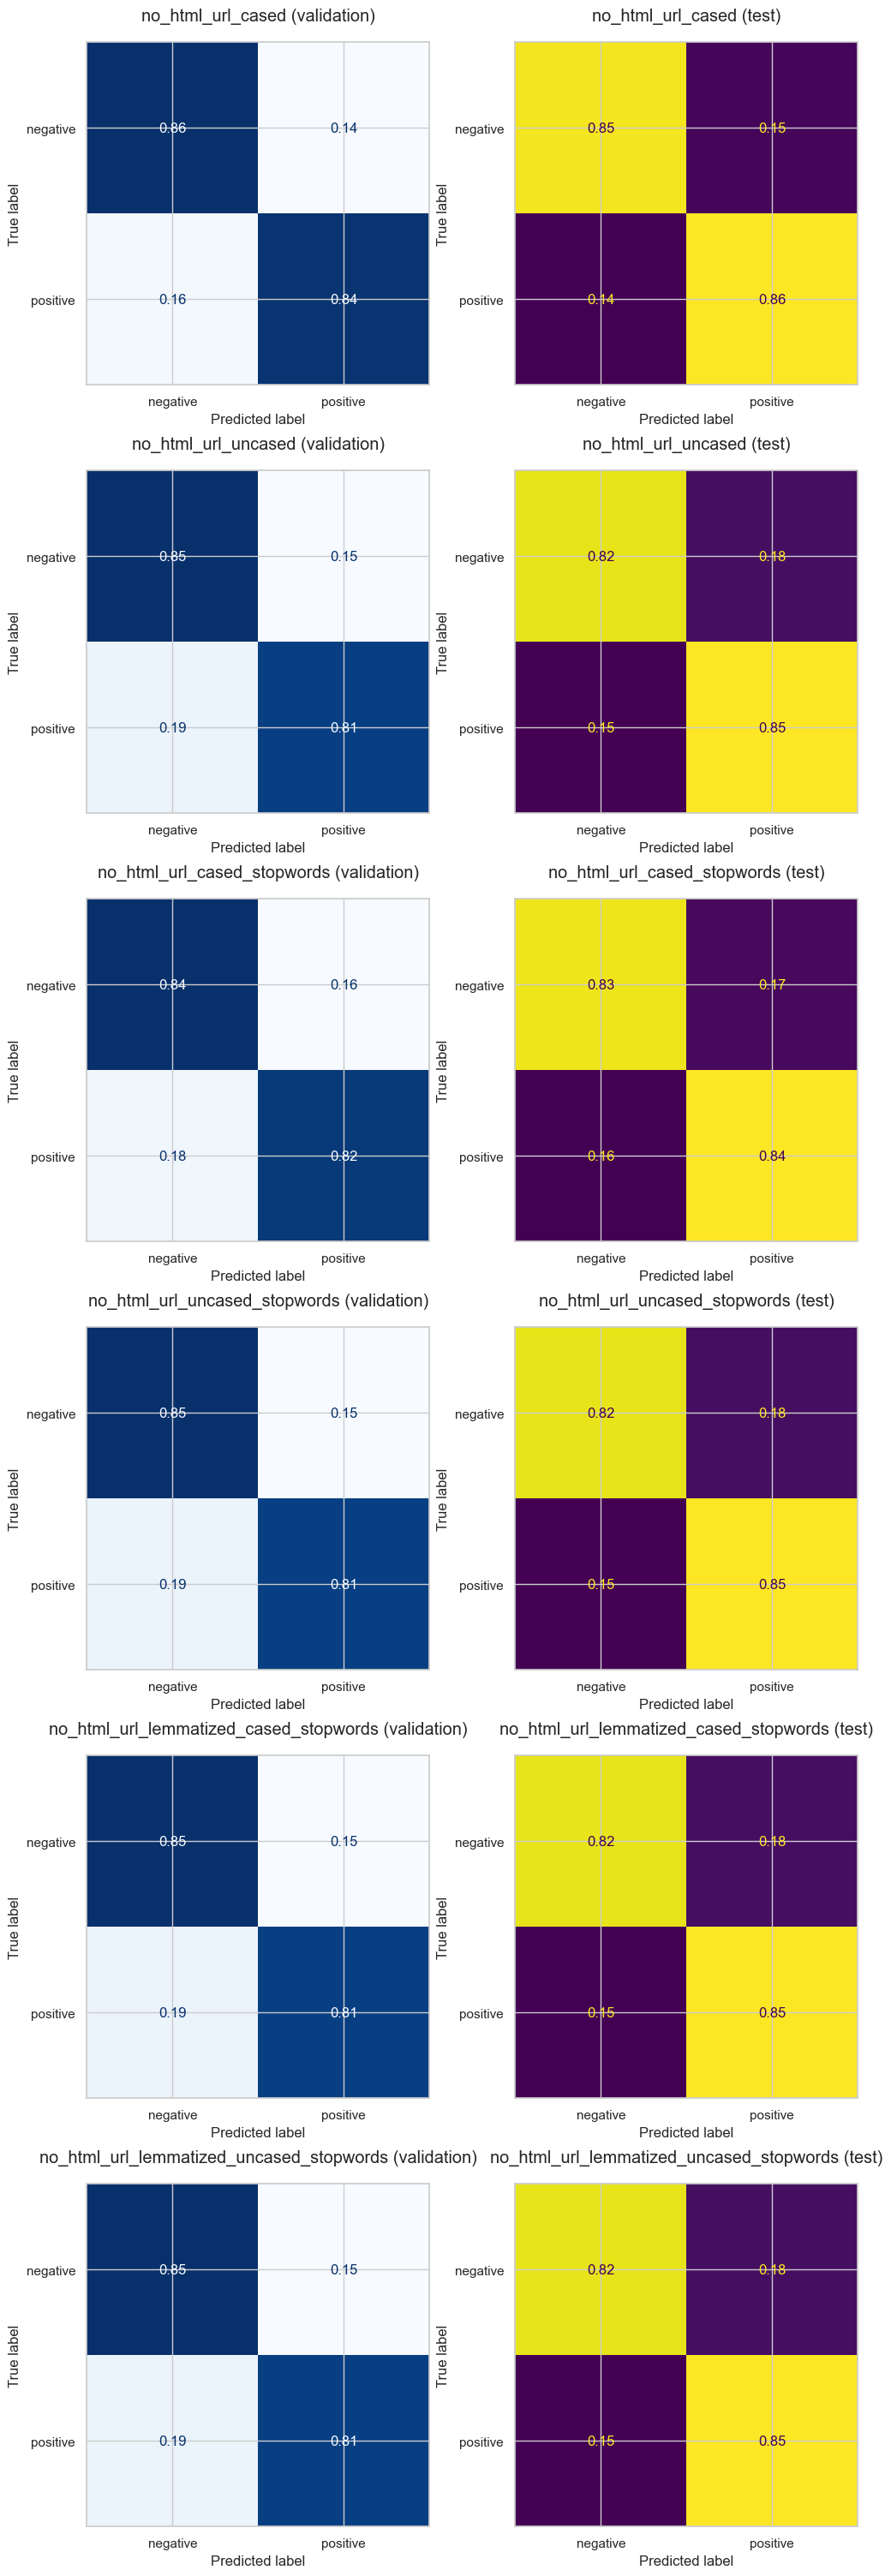

In [268]:

results_distilbert: dict = uncased_experiments_results | cased_experiments_results
descriptor_feature_extractor = ExperimentDescriptor(EXPERIMENTS, pd.DataFrame(data=results_distilbert))
descriptor_feature_extractor.plot_confusion_matrices(classifier.classes_)

with open('distilbert_results.pickle', 'wb') as handle:
    pk.dump(results_distilbert, handle, protocol=pk.HIGHEST_PROTOCOL)


We can observe that the more we process the review, the worse the logistic regression performs. The best precision is obtained when we delete the HTML tags and the URLs, keeping the cased words (`no_html_url_cased`). Exactly, we get an precision of 0.85 when detecting negative reviews and 0.86 for the positive ones.

### BERT experiments

We consider the BERT encoder to run more experiments. Since this architecture is bigger than the DistilBERT, we expect longer times when extracting the hidden states for the train, validation and test splits.

#### Cased experiments

In [203]:
from transformers import BertTokenizer

model_name: str = "bert-base-cased"
bert_tokenizer_hugging_face = BertTokenizer.from_pretrained(model_name)
bert_transformer_hugging_face =  AutoModel.from_pretrained(model_name).to(DEVICE)

bert_cased_tokenizer: TransformerTokenizer = TransformerTokenizer(bert_tokenizer_hugging_face)
transformer_cased_bert: Transformer = Transformer(transformer=bert_transformer_hugging_face, transformer_tokenizer=bert_cased_tokenizer)

cased_experiments_results_bert: dict = dict()
for experiment in CASED_EXPERIMENTS:

    classifier = LogisticRegression(max_iter=3000)
    runner = ExperimentRunner(
        transformer = transformer_cased_bert,
        tokenizer = bert_cased_tokenizer,
        experiment_name=experiment,
        experiment=EXPERIMENTS[experiment],
        model_folder='bert'
    )

    start_time = time.time()
    print(f"[{experiment}] Extracting features...")
    experiment_features = runner.extract_features()
    end_time = time.time()

    print(f"[{experiment}] Training and validating classifier head...")
    predictions_validation, cm_val = runner.train_validate_classification_layer(classifier)

    print(f"[{experiment}] Training and testing classifier head...")
    predictions_test, cm_test = runner.test_classification_layer(LogisticRegression(max_iter=3000))

    print(f'[{experiment}] Saving results...')
    cased_experiments_results_bert[experiment] = {
    'predictions_validation' : {
        'predictions' : predictions_validation,
        'confusion_matrix' : cm_val
    },
    'test_predictions' : {
        'predictions': predictions_test,
        'confusion_matrix' : cm_test
    },
    'feature_extraction_time' : end_time - start_time}

[no_html_url_cased] Extracting features...


Map: 100%|██████████| 2000/2000 [01:07<00:00, 29.81 examples/s]


Finished extracting the hidden states for no_html_url_cased. Persisting in disk...


Saving the dataset (1/1 shards): 100%|██████████| 2000/2000 [00:00<00:00, 375161.36 examples/s]


[no_html_url_cased] Training and validating classifier head...
[no_html_url_cased] Training and testing classifier head...
[no_html_url_cased] Saving results...
[no_html_url_cased_stopwords] Extracting features...


Map: 100%|██████████| 2000/2000 [01:07<00:00, 29.74 examples/s]


Finished extracting the hidden states for no_html_url_cased_stopwords. Persisting in disk...


Saving the dataset (1/1 shards): 100%|██████████| 2000/2000 [00:00<00:00, 484834.59 examples/s]


[no_html_url_cased_stopwords] Training and validating classifier head...
[no_html_url_cased_stopwords] Training and testing classifier head...
[no_html_url_cased_stopwords] Saving results...
[no_html_url_lemmatized_cased_stopwords] Extracting features...


Map: 100%|██████████| 2000/2000 [01:07<00:00, 29.68 examples/s]


Finished extracting the hidden states for no_html_url_lemmatized_cased_stopwords. Persisting in disk...


Saving the dataset (1/1 shards): 100%|██████████| 2000/2000 [00:00<00:00, 401388.01 examples/s]


[no_html_url_lemmatized_cased_stopwords] Training and validating classifier head...
[no_html_url_lemmatized_cased_stopwords] Training and testing classifier head...
[no_html_url_lemmatized_cased_stopwords] Saving results...


#### Uncased experiments

In [209]:
model_name: str = "bert-base-uncased"
bert_uncased_tokenizer_hugging_face = BertTokenizer.from_pretrained(model_name)
bert_uncased_transformer_hugging_face =  AutoModel.from_pretrained(model_name).to(DEVICE)

bert_uncased_tokenizer: TransformerTokenizer = TransformerTokenizer(bert_uncased_tokenizer_hugging_face)
transformer_uncased_bert: Transformer = Transformer(transformer=bert_uncased_transformer_hugging_face, transformer_tokenizer=bert_uncased_tokenizer)

uncased_experiments_results_bert: dict = dict()
for experiment in UNCASED_EXPERIMENTS:

    classifier = LogisticRegression(max_iter=3000)
    runner = ExperimentRunner(
        transformer = transformer_uncased_bert,
        tokenizer = bert_uncased_tokenizer,
        experiment_name=experiment,
        experiment=EXPERIMENTS[experiment],
        model_folder='bert'
    )

    start_time = time.time()
    print(f"[{experiment}] Extracting features...")
    experiment_features = runner.extract_features()
    end_time = time.time()

    print(f"[{experiment}] Training and validating classifier head...")
    predictions_validation, cm_val = runner.train_validate_classification_layer(classifier)

    print(f"[{experiment}] Training and testing classifier head...")
    predictions_test, cm_test = runner.test_classification_layer(LogisticRegression(max_iter=3000))

    print(f'[{experiment}] Saving results...')
    uncased_experiments_results_bert[experiment] = {
    'predictions_validation' : {
        'predictions' : predictions_validation,
        'confusion_matrix' : cm_val
    },
    'test_predictions' : {
        'predictions': predictions_test,
        'confusion_matrix' : cm_test
    },
    'feature_extraction_time' : end_time - start_time}

[no_html_url_uncased] Extracting features...


Map: 100%|██████████| 2000/2000 [01:06<00:00, 30.04 examples/s]


Finished extracting the hidden states for no_html_url_uncased. Persisting in disk...


Saving the dataset (1/1 shards): 100%|██████████| 2000/2000 [00:00<00:00, 475733.45 examples/s]


[no_html_url_uncased] Training and validating classifier head...
[no_html_url_uncased] Training and testing classifier head...
[no_html_url_uncased] Saving results...
[no_html_url_uncased_stopwords] Extracting features...


Map: 100%|██████████| 2000/2000 [01:06<00:00, 30.02 examples/s]


Finished extracting the hidden states for no_html_url_uncased_stopwords. Persisting in disk...


Saving the dataset (1/1 shards): 100%|██████████| 2000/2000 [00:00<00:00, 485929.91 examples/s]


[no_html_url_uncased_stopwords] Training and validating classifier head...
[no_html_url_uncased_stopwords] Training and testing classifier head...
[no_html_url_uncased_stopwords] Saving results...
[no_html_url_lemmatized_uncased_stopwords] Extracting features...


Map: 100%|██████████| 2000/2000 [01:06<00:00, 30.02 examples/s]


Finished extracting the hidden states for no_html_url_lemmatized_uncased_stopwords. Persisting in disk...


Saving the dataset (1/1 shards): 100%|██████████| 2000/2000 [00:00<00:00, 476435.96 examples/s]


[no_html_url_lemmatized_uncased_stopwords] Training and validating classifier head...
[no_html_url_lemmatized_uncased_stopwords] Training and testing classifier head...
[no_html_url_lemmatized_uncased_stopwords] Saving results...


#### Results

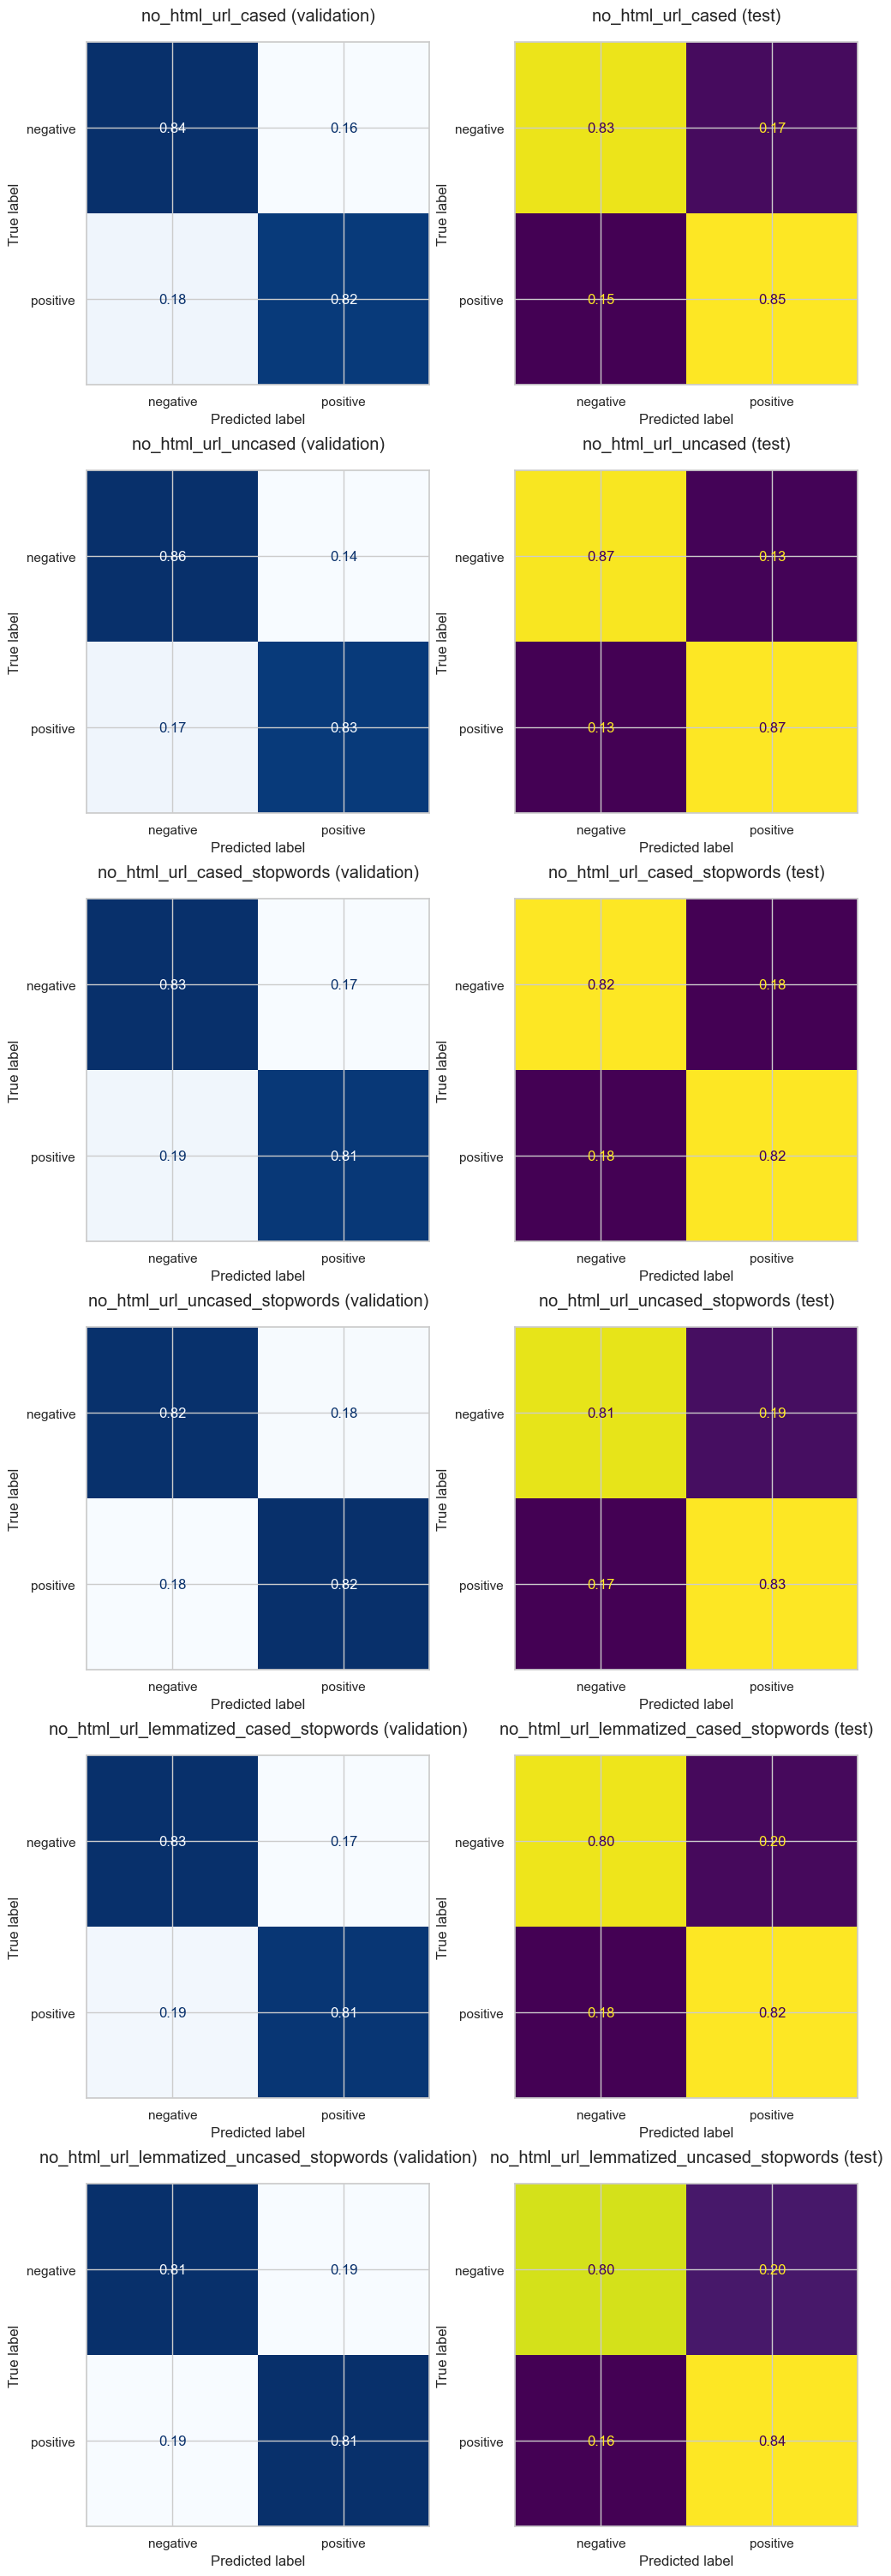

In [213]:
results_bert: dict = uncased_experiments_results_bert | cased_experiments_results_bert
descriptor_feature_extractor_bert = ExperimentDescriptor(EXPERIMENTS, pd.DataFrame(data=results_bert))
descriptor_feature_extractor_bert.plot_confusion_matrices(classifier.classes_)

with open('bert_results.pickle', 'wb') as handle:
    pk.dump(results_bert, handle, protocol=pk.HIGHEST_PROTOCOL)

In detriment of longer extraction times, compared with DistilBERT, BERT yields better results when we remove the HTML tags and uncase all the words of every review. Exactly, we get a precision of 0.87 when detecting negative and positive reviews.

## 4.2 Using a Fine tuned model

We developed systems without any fine tunning any model. In this section we will use a fine tuned model to address the sentiment analysis task. We use a model already uploaded to HuggingFace that was fine tuned for the sentiment analysis task. Given the test set we computed before, we show the confusion matrix obtained by the predictions made by the fine tuned model.

To do so, we use the `pipeline` HuggingFace class and instantiate a pipeline for the model `federicopascual/finetuning-sentiment-model-3000-samples`. This model is is obtained by fine tunning `distilbert-base-uncased` base model over the IMDB dataset. Thus, in the experiment proposed above, we only consider the one that removes the HTML tags and lower case all the words of the reviews.

In [215]:
from transformers import pipeline
 
sentiment_model = pipeline(model="federicopascual/finetuning-sentiment-model-3000-samples")
sentiment_model(["I love this move", "This movie sucks!"])

config.json: 100%|██████████| 615/615 [00:00<00:00, 1.66MB/s]
pytorch_model.bin: 100%|██████████| 268M/268M [00:11<00:00, 22.5MB/s] 
tokenizer_config.json: 100%|██████████| 333/333 [00:00<00:00, 879kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 1.14MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 1.26MB/s]
special_tokens_map.json: 100%|██████████| 112/112 [00:00<00:00, 426kB/s]


[{'label': 'LABEL_1', 'score': 0.9558863043785095},
 {'label': 'LABEL_0', 'score': 0.9413503408432007}]

`LABEL_1` refers to positive statements, `LABEL_0` to negative ones.

In [317]:
model_folder_path: str = f'/Users/alvarito/Documents/Github/NNLP/experiments/data/no_html_url_uncased/distilbert/'
dataset_uncased = datasets.load_from_disk(model_folder_path)

In [318]:
test_texts: list = dataset_uncased['test']['text']
y_true = dataset_uncased['test']['target']

Since the fine tuned model only admits reviews that do not have more than 512 tokens (inferred by the DistilBERT tokenized) we need to limit the length of our reviews. We consider that each review of our dataset is cropped up to 300 words, considering that a word is limited by the whitespace character.

In [246]:
test_texts_cropped = list()
for text in test_texts:
    tokenized = text.split()
    test_texts_cropped.append(" ".join(tokenized[:300]))

We predict the sentiment of each review given the pretrained model for our task.

In [247]:
predictions = sentiment_model(test_texts_cropped)

And we tidy up the predictions made by the model.

In [316]:
y_pred: list = list()
for prediction in predictions:

    pred = 'positive'
    if prediction['label'] == 'LABEL_0':
        pred = 'negative'

    y_pred.append(pred)

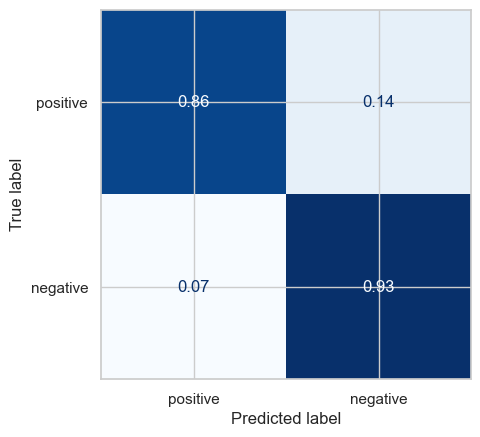

In [256]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive', 'negative'])
disp.plot(cmap="Blues", values_format=".2f", colorbar=False)

With the fine tuned model we get a precision fo 0.86 when detecting positive reviews and 0.93 when detecting the negative ones. Overall, we get similar results when using BERT or DistilBERT as a feature extractor.
The time is way lower than the obtained when using BERT and DistilBERT as a feature extractors.

In [320]:
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.93      0.86      0.89      1003
    positive       0.87      0.93      0.90       997

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



If we look to the classification report above, we get that the macro average of $F_1 = 0.90$. This outperforms all the experiments run for DistilBERT and BERT. 

## 4.3 Model size VS timings VS results

In the table below we show the model size, timings when extracting the hidden features and the results of every experiment we considered. To measure the performance of each experiment, we consider the $F_1$ value which is given by:

$F_\beta = (1 + \beta^2) \cdot \frac{precision \cdot recall}{ \beta \cdot precision + recall}$. Since we consider that the system should predict properly negative and positive reviews, we consider that precision and recall are equally important. Hence in this case $\beta = 1$. With this assumption, $F_1$ yields the harmonic mean between the precision and recall.

The model sizes for each proposed architectures are:

In [ ]:
AutoModel.from_pretrained("distilbert-base-uncased").to(DEVICE).num_parameters()

In [314]:
display(f'Uncased BERT: {bert_uncased_transformer_hugging_face.num_parameters()} parameters')
display(f'Cased BERT: {bert_transformer_hugging_face.num_parameters()} parameters')

display(f'Uncased DistilBERT: {AutoModel.from_pretrained("distilbert-base-uncased").to(DEVICE).num_parameters()} parameters')
display(f'Cased DistilBERT: {AutoModel.from_pretrained("distilbert-base-cased").to(DEVICE).num_parameters()} parameters')


'Uncased BERT: 109482240 parameters'

'Cased BERT: 108310272 parameters'

'Uncased DistilBERT: 66362880 parameters'

'Cased DistilBERT: 65190912 parameters'

DistilBERT has less parameters compared to BERT. The training or extraction of hidden states time is proportional to the number of parameters. The more parameters we have, the longer it will take to train/extract hidden states.

Lastly we compute the $F_1$ score for each experiment and we show the consumed time to extract the hidden states when considering the transformer as a feature extractor.

We read the results

In [286]:
with open('distilbert_results.pickle', 'rb') as d_result:
    distilbert_res = pk.load(d_result)

with open('bert_results.pickle', 'rb') as b_result:
    bert_res = pk.load(b_result)

And we read the test set since we compute the metrics with this data split.

In [279]:
model_folder_path: str = f'/Users/alvarito/Documents/Github/NNLP/experiments/data/no_html_url_uncased/distilbert/'
dataset_uncased = datasets.load_from_disk(model_folder_path)
test_texts: list = dataset_uncased['test']['text']
y_true = dataset_uncased['test']['target']

Then for the DistilBERT predictions, we compute the performance metric.

In [297]:
from sklearn.metrics import classification_report

for experiment in EXPERIMENTS.keys():
    results = distilbert_res[experiment]
    predictions_test = results['test_predictions']['predictions']
    
    re = classification_report(y_true=y_true, y_pred=predictions_test, target_names=['negative', 'positive'], output_dict=True)

    distilbert_res[experiment]['precision'] = round(re['macro avg']['precision'], 3)
    distilbert_res[experiment]['recall'] = round(re['macro avg']['recall'], 3)
    distilbert_res[experiment]['f1'] = round(re['macro avg']['f1-score'], 3)

In [307]:
distilbert_res_df = pd.DataFrame(distilbert_res)
distilbert_res_df.loc[['feature_extraction_time', 'f1']]

,no_html_url_uncased,no_html_url_uncased_stopwords,no_html_url_lemmatized_uncased_stopwords,no_html_url_cased,no_html_url_cased_stopwords,no_html_url_lemmatized_cased_stopwords
feature_extraction_time,216.623902,212.859754,213.466146,217.805228,211.345719,211.315342
f1,0.835,0.835,0.835,0.858,0.836,0.835


And the same for the BERT predictions.

In [299]:
for experiment in EXPERIMENTS.keys():
    results = bert_res[experiment]
    predictions_test = results['test_predictions']['predictions']
    
    re = classification_report(y_true=y_true, y_pred=predictions_test, target_names=['negative', 'positive'], output_dict=True)

    bert_res[experiment]['precision'] = round(re['macro avg']['precision'], 3)
    bert_res[experiment]['recall'] = round(re['macro avg']['recall'], 3)
    bert_res[experiment]['f1'] = round(re['macro avg']['f1-score'], 3)

In [306]:
bert_res_df = pd.DataFrame(bert_res)
bert_res_df.loc[['feature_extraction_time', 'f1']]


,no_html_url_uncased,no_html_url_uncased_stopwords,no_html_url_lemmatized_uncased_stopwords,no_html_url_cased,no_html_url_cased_stopwords,no_html_url_lemmatized_cased_stopwords
feature_extraction_time,381.775645,377.705152,377.743217,379.929904,378.60498,379.494661
f1,0.869,0.82,0.821,0.843,0.816,0.813


If we compare both dataframes, we note that, compared to DistilBERT, BERT model takes longer when extracting the hidden states. However, it yields the best model when we remove the HTML tags and lower case all the words.
In contrast, with DistilBERT we get shorter extraction times but the best result (`no_html_url_cased`) is worse than the best one obtained with BERT. In our case, BERT is 1.1% better than DistilBERT if we compute the differences between the best metrics of each model.

# 5. Conclusions

Using pretrained models can be more effective than using classic machile learning models. However, pretrained models are limited to the dataset they are trained and to the computational resources to train their base model. 

In our task, we get relatively good results (macro average of $F_1 = 0.90$) when using a fine tuned model for the sentiment analysis task (`federicopascual/finetuning-sentiment-model-3000-samples` model) considering that we are cropping the number of words per review due to the limitation that transformers are only capable of working with limited number of tokens (computed by their respective tokenizers). In less than a minute we got better predictions that when using BERT or DistilBERT as feature extractors.

Due to the number of parameters, BERT has way more parameters than the ones of DistilBERT for cased/uncased words. Due to this, bigger feature extraction seconds (`feature_extraction_time` from the dataframes depicted above) are obtained when using BERT but better predictions are obtained compared to DistilBERT.